In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import akshare as ak
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

!python --version

Python 3.8.10


In [2]:
import tensorflow as tf

# 只使用CPU进行训练
tf.config.set_visible_devices([], 'GPU')

# 打印Tensorflow版本
print(f"Tensorflow Version: {tf.__version__}")

# 检查是否有可用的GPU设备
if tf.test.is_built_with_cuda():
    print("TensorFlow GPU version is installed")
else:
    print("TensorFlow CPU version is installed")

# 检查TensorFlow是否能够访问GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices available:", gpus)
else:
    print("No GPU devices found. Running on CPU.")

# !nvidia-smi

2024-05-05 07:36:53.397472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 07:36:54.154985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow Version: 2.13.1
TensorFlow GPU version is installed
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, StandardScaler

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 绘图相关函数
def plot_series_dist(series):
    data = series
    plt.figure(figsize=(5,5))
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

def plot_metrics(history):
  metrics = ['loss', 'mean_absolute_error', 'mean_squared_error']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0, plt.ylim()[1]])
    plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_close_label(df, label_name='label'):
    # 设置图像的大小
    plt.figure(figsize=(14, 7))
    # 绘制收盘价曲线
    plt.plot(df['datetime'], df['close'], label='Close Price', color='blue')
    # 提取买入和卖出点
    buy_points = df[df[label_name] == 1]
    sell_points = df[df[label_name] == 2]
    # 在买入点绘制上升三角形标记
    plt.scatter(buy_points['datetime'], buy_points['close'], label='Buy', color='green', marker='^', alpha=1)
    # 在卖出点绘制下降三角形标记
    plt.scatter(sell_points['datetime'], sell_points['close'], label='Sell', color='red', marker='v', alpha=1)
    # 增加标题和标签
    plt.title('Stock Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # 显示图例
    plt.legend()
    # 展示图形
    plt.show()

In [5]:
class PreProcessing:
    def __init__(self, db_downloader:DownloaderBase) -> None:
        self.db_downloader = db_downloader

    def _build_cls_label(self, stock_dataframe):
        """
        明日开始未来N天内优先触发止盈 = 1, 触发止损=2, 其他=0
        """
        def calculate_atr(df, period=14):
            df['high-low'] = df['high'] - df['low']
            df['high-close_prev'] = abs(df['high'] - df['close'].shift(1))
            df['low-close_prev'] = abs(df['low'] - df['close'].shift(1))
            df['tr'] = df[['high-low', 'high-close_prev', 'low-close_prev']].max(axis=1)
            atr = df['tr'].rolling(window=period, min_periods=1).mean()
            return atr

        # 初始化标签参数
        N = 15 # 时间周期
        ATR_period = 14 # ATR计算周期
        ATR_take_profit_factor = 3 # 止盈参数
        ATR_stop_loss_factor = 2 # 止损参数
        # 开始构建标签
        df = stock_dataframe.copy()
        # 1. 计算标签构建所需要的指标
        df['atr'] = calculate_atr(df, period=ATR_period) # 计算每一天的ATR
        df['label'] = 0  # 初始化标签列
        df['return'] = np.NaN # 初始化收益率列
        df['duration'] = np.NaN
        # 2. 轮询判断先止盈还是先止损
        for index in range(len(df)-N):
            buy_price = df.at[index, 'close']
            buy_atr = df.at[index, 'atr'] # 获取过去N天的ATR
            take_profit_price = buy_price + ATR_take_profit_factor * buy_atr # 提前确定止盈价格
            stop_loss_price = buy_price - ATR_stop_loss_factor * buy_atr # 提前确定止损价格
            for day in range(1, N+1):
                future_day_high = df.at[index+day, 'high'] # 买入后每天的最高价
                future_day_low = df.at[index+day, 'low'] # 买入后每天的最低价
                future_day_close = df.at[index+day, 'close'] # 买入后每天的收盘价
                # 检查价格是否触发止盈或止损条件
                if future_day_high > take_profit_price:
                    df.at[index, 'label'] = 1  # 未来N日走势上升 + 突破止盈
                    df.at[index, 'return'] = (future_day_close / buy_price) - 1
                    df.at[index, 'duration'] = day
                    break  # 退出内循环
                elif future_day_low < stop_loss_price:
                    df.at[index, 'label'] = 2  # 未来N日走势下降 + 突破止损
                    df.at[index, 'return'] = (future_day_close / buy_price) - 1
                    df.at[index, 'duration'] = day
                    break  # 退出内循环
            else:
                df.at[index, 'return'] = (future_day_close / buy_price) - 1
                df.at[index, 'duration'] = day
        # 过滤第二天一字涨停情况
        df = df[df['high'].shift(-1) != df['low'].shift(-1)]
        return df[['datetime', 'label', 'return', 'atr', 'duration']]

    def _process_one_stock(self, stock_code, start_date, end_date):
        stock_base = self.db_downloader._download_stock_base_info(stock_code) # 获取基础代码
        stock_individual = self.db_downloader._download_stock_individual_info(stock_code) # 获取profile信息
        stock_history = self.db_downloader._download_stock_history_info(stock_code, start_date, end_date) # 获取历史行情
        stock_indicator = self.db_downloader._download_stock_indicator_info(stock_code, start_date, end_date) # 获取指标数据
        stock_factor_date = self.db_downloader._download_stock_factor_date_info() # 获取日期特征
        stock_factor_qlib = self.db_downloader._download_stock_factor_qlib_info(stock_code, start_date, end_date) # 获取量价特征
        stock_label = self._build_cls_label(stock_history, ) # 构建Label
        stock_df = stock_base.merge(stock_individual, on=['stock_code']).merge(stock_history, on=['stock_code']).merge(stock_indicator, on=['stock_code', 'datetime']).merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_base \
            .merge(stock_individual, on=['stock_code', 'stock_name']) \
            .merge(stock_history, on=['stock_code']) \
            .merge(stock_indicator, on=['stock_code', 'datetime']) \
            .merge(stock_label, on=['datetime']) \
            .merge(stock_factor_date, on=['datetime']) \
            .merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_df.dropna()
        return stock_df
    
    def _process_all_stock(self, code_type, start_date, end_date):
        # stock_code_list = list(ak.stock_info_a_code_name()['code'].unique()) # 获取A股所有股票列表
        stock_code_list = list(ak.index_stock_cons(code_type)['品种代码'].unique()) # 获取沪深300的股票代码列表
        stock_df_list = []
        for stock_code in tqdm(stock_code_list, desc=f'Process: {code_type} ...'):
            stock_df = self._process_one_stock(stock_code, start_date, end_date)
            if not stock_df.empty:
                stock_df_list.append(stock_df)
        return pd.concat(stock_df_list)

In [6]:
# 数据库初始化
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)
proprocessor = PreProcessing(db_downloader=db_downloader)
# df = proprocessor._process_all_stock('000016', '20100101', '20110101')

In [7]:
# df.label.value_counts()

In [8]:
# print(df.stock_code.unique())
# sample_df = df[df['stock_code'] == '600036']
# plot_close_label(sample_df)

In [9]:
# sample_df.tail(20)

In [10]:
def get_rolling_data_period(backtest_start_date, backtest_duration=5, train_period=6, val_period=0.5, test_period=0.5):
    """
    Args:
        backtest_start_date (_type_): _description_
        backtest_duration (int, optional): _description_. Defaults to 5.
        train_period (int, optional): _description_. Defaults to 6.
        val_period (float, optional): _description_. Defaults to 0.5.
        test_period (float, optional): _description_. Defaults to 0.5.
    Returns:
        result: _description_
    """
    backtest_start_date = datetime.strptime(backtest_start_date, '%Y%m%d')
    backtest_end_date = backtest_start_date + relativedelta(years=backtest_duration) # 回测5年数据
    train_period = relativedelta(years=train_period) # 使用6年的训练数据
    val_period = relativedelta(months=(12 * val_period)) # 使用半年的验证数据
    test_period = relativedelta(months=(12 * test_period)) # 使用半年的测试数据(半年模型一更新)

    result = []
    rolling_flag = True
    bench_date = backtest_start_date
    while rolling_flag:
        if bench_date < backtest_end_date:
            test_start, test_end = bench_date, (bench_date + test_period - relativedelta(days=1))
            val_start, val_end = (test_start - relativedelta(days=1) - val_period), (test_start - relativedelta(days=1))
            train_start, train_end =(val_start - relativedelta(days=1) - train_period), (val_start - relativedelta(days=1))
            result.append({
                "train": [train_start.strftime("%Y%m%d"), train_end.strftime("%Y%m%d")],
                "val": [val_start.strftime("%Y%m%d"), val_end.strftime("%Y%m%d")],
                "test": [test_start.strftime("%Y%m%d"), test_end.strftime("%Y%m%d")]
            })
            bench_date += test_period
        else:
            rolling_flag = False 
    return result

def extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    test_start_date = pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)

    train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
    val_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]
    test_data = df[(pd.to_datetime(df['datetime']) >= test_start_date) & (pd.to_datetime(df['datetime']) <= test_end_date)]

    print(f"train_data_size: {train_data.shape}")
    print(f"validation_data_size: {val_data.shape}")
    print(f"test_data_size: {test_data.shape}")
    return train_data, val_data, test_data

def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=True, batch_size=32):
    features = dataframe[feature_cols]
    labels = dataframe[label_cols]
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(features), 10000))
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_process=True, minmax_scale=True, standard_scale=False):
        # 配置异常值处理
        self.outlier_process = outlier_process
        self.outlier_params = {}
        # 配置MinMaxScaler
        self.minmax_scale = minmax_scale
        # 配置StandardScaler
        self.standard_scale = standard_scale
        
    def _fit_outlier_cap(self, X):
        # 计算并存储异常值处理参数
        lower_bound, upper_bound = np.nanpercentile(X, [0.01, 0.99], axis=0)
        self.outlier_params['outliers_lower_bounds_'] = lower_bound
        self.outlier_params['outliers_upper_bounds_'] = upper_bound
        
    def _transform_outlier_cap(self, X):
        # 根据存储的参数应用异常值限制
        return np.clip(X, self.outlier_params['outliers_lower_bounds_'], self.outlier_params['outliers_upper_bounds_'])
    
    def fit(self, X, y=None):
        if self.outlier_process:
            self._fit_outlier_cap(X)
        self.scalers_ = []
        if self.minmax_scale:
            minmax_scaler = MinMaxScaler()
            minmax_scaler.fit(X)
            self.scalers_.append(minmax_scaler)
        if self.standard_scale:
            standard_scaler = StandardScaler()
            standard_scaler.fit(X)
            self.scalers_.append(standard_scaler)
        return self
    
    def transform(self, X, y=None):
        if self.outlier_process:
            X = self._transform_outlier_cap(X)
        # 应用归一化和标准化转换
        for scaler in self.scalers_:
            X = scaler.transform(X)
        return X

In [12]:
# 相关配置
rolling_flag = False
benchmark = '000016'
feature_config = {
    "target_features": ['label'],
    "numeric_features": ['turnover_rate', 'pe_ttm', 'ps_ttm', 'pcf_ncf_ttm', 'pb_mrq', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60'],
    "integer_categorical_features": ['month'],
    "string_categorical_features": ['industry', 'season'],
}
batch_size = 1024

# 是否开启滚动训练&回测
if rolling_flag:
    print("开启滚动回测...")
    backtest_period = get_rolling_data_period(
        backtest_start_date='20200101', # 回测开始日期
        backtest_duration=4, # 一共回测多久的数据（单位：年）
        train_period=6, # 使用过去多久的时间进行训练（单位：年）
        val_period=1, # 验证数据周期（单位：年）
        test_period=1, # 测试数据周期（单位：年）
    )
else:
    print("关闭滚动回测...")
    backtest_period = [
        {
            'train': ['20120101', '20171231'],
            'val': ['20180101', '20181231'],
            'test': ['20190101', '20231231']
        }
    ]

backtest_period

关闭滚动回测...


[{'train': ['20120101', '20171231'],
  'val': ['20180101', '20181231'],
  'test': ['20190101', '20231231']}]

In [13]:
# feature_columns = feature_config.get('numeric_features', []) + feature_config.get('integer_categorical_features', []) + feature_config.get('string_categorical_features', [])
# label_columns = feature_config.get('target_features', [])
# ds = df_to_dataset(df, feature_columns, label_columns, shuffle=True, batch_size=batch_size)

In [14]:
date_period_params = backtest_period[0]
print(date_period_params)
train_start_date, train_end_date = date_period_params['train']
val_start_date, val_end_date = date_period_params['val']
test_start_date, test_end_date = date_period_params['test']
# 获取全区间数据
print("开始加载原始数据...")
df = proprocessor._process_all_stock(code_type=benchmark, start_date=train_start_date, end_date=test_end_date)
# 抽取训练验证数据
print("开始拆分训练、验证、测试集合...")
train_data, val_data, test_data = extract_train_val_data(df, *[train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, test_end_date])
# 计算类别权重
print("开始计算类别权重...")
value_count = train_data['label'].value_counts()
print(value_count)
total_count = train_data['label'].count()
class_weights = ((1 / value_count) * (total_count / 2.0)).to_dict()
class_weights

{'train': ['20120101', '20171231'], 'val': ['20180101', '20181231'], 'test': ['20190101', '20231231']}
开始加载原始数据...


Process: 000016 ...: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


开始拆分训练、验证、测试集合...
train_data_size: (47939, 210)
validation_data_size: (9544, 210)
test_data_size: (55152, 210)
开始计算类别权重...
0    17810
1    15145
2    14984
Name: label, dtype: int64


{0: 1.3458450308815273, 1: 1.5826675470452296, 2: 1.5996729845168178}

In [15]:
# 从data中抽取相关特征数据
print("开始抽取特征数据...")
feature_columns = feature_config.get('numeric_features', []) + feature_config.get('integer_categorical_features', []) + feature_config.get('string_categorical_features', [])
label_columns = feature_config.get('target_features', [])
full_feature_columns = feature_columns + label_columns
train_df, val_df, test_df = train_data[full_feature_columns], val_data[full_feature_columns], test_data[full_feature_columns]
# 对相关特征进行特征工程
print("开始特征工程处理...")
feature_preprocess_pipeline = CustomPreprocessor(outlier_process=False)
preprocess_feature_columns = feature_config.get('numeric_features', [])
train_df[preprocess_feature_columns] = feature_preprocess_pipeline.fit_transform(train_df[preprocess_feature_columns])
val_df[preprocess_feature_columns] = feature_preprocess_pipeline.transform(val_df[preprocess_feature_columns])
test_df[preprocess_feature_columns] = feature_preprocess_pipeline.transform(test_df[preprocess_feature_columns])
# 转换为tensorflow所使用的dataset
print("开始将DataFrame转换为DataSet...")
train_ds = df_to_dataset(train_df, feature_columns, label_columns, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val_df, feature_columns, label_columns, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, feature_columns, label_columns, shuffle=False, batch_size=batch_size) 

开始抽取特征数据...
开始特征工程处理...
开始将DataFrame转换为DataSet...


In [17]:
# 准备模型训练
print("开始模型初始化 & 训练...")
from models.single_task.model_moe import QuantModel
model_config = {
        "seed": 1024,
        "output_dim": 3,
        "feature_use_embedding": True,
        "feature_embedding_dims": 4,
        "dnn_hidden_units": [64,32,16],
        "expert_nums": 6,
        "numeric_features_with_boundaries": {k: pd.qcut(train_df[k], q=40, retbins=True, duplicates='drop')[1].tolist() for k in feature_config.get('numeric_features', [])},
        "integer_categorical_features_with_vocab": {k: list(train_df[k].unique()) for k in feature_config.get('integer_categorical_features', [])},
        "string_categorical_features_with_vocab": {k: list(train_df[k].unique()) for k in feature_config.get('string_categorical_features', [])},
    }
model = QuantModel(config=model_config)

# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     initial_learning_rate,
#     decay_steps=(len(train_data) // batch_size)*5,
#     decay_rate=1,
#     staircase=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
    ]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

baseline_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks = [early_stopping],
    class_weight=class_weights
)

开始模型初始化 & 训练...
Epoch 1/500
47/47 [==============================] - 46s 396ms/step - loss: 2.1339 - sparse_categorical_accuracy: 0.3384 - val_loss: 1.1376 - val_sparse_categorical_accuracy: 0.3179
Epoch 2/500
47/47 [==============================] - 16s 338ms/step - loss: 1.9078 - sparse_categorical_accuracy: 0.3481 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.3320
Epoch 3/500
47/47 [==============================] - 17s 351ms/step - loss: 1.8114 - sparse_categorical_accuracy: 0.3609 - val_loss: 1.1243 - val_sparse_categorical_accuracy: 0.3317
Epoch 4/500
47/47 [==============================] - 16s 350ms/step - loss: 1.7749 - sparse_categorical_accuracy: 0.3641 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.3393
Epoch 5/500
47/47 [==============================] - 17s 361ms/step - loss: 1.7349 - sparse_categorical_accuracy: 0.3694 - val_loss: 1.1086 - val_sparse_categorical_accuracy: 0.3415
Epoch 6/500
47/47 [==============================] - 17s 370ms/step - loss

In [18]:
# test数据处理
test_cls_result = model.predict(test_ds)

54/54 [==============================] - 8s 121ms/step


In [19]:
from sklearn.metrics import classification_report
test_true = test_data['label']
test_pred = np.argmax(tf.nn.softmax(test_cls_result), axis=-1)
print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47     19277
           1       0.31      0.25      0.28     15563
           2       0.40      0.33      0.36     20312

    accuracy                           0.39     55152
   macro avg       0.37      0.38      0.37     55152
weighted avg       0.38      0.39      0.38     55152



In [20]:
# 输出回测预测
print("开始保存回测预测结果...")
test_cls_result = model.predict(test_ds)
test_cls_softmax = tf.nn.softmax(test_cls_result)
output_df = test_data[['stock_code', 'stock_name', 'datetime', 'open', 'high', 'low', 'close', 'volume']]
output_df['label'] = test_df['label']
output_df['label_pred'] = np.argmax(test_cls_softmax, axis=-1)
output_df['label_prob'] = np.max(test_cls_softmax, axis=-1)
output_df.to_pickle(f'../../Offline/backtest/backtest_data/test/{benchmark}_{test_start_date}_分类任务.pkl') 

开始保存回测预测结果...
54/54 [==============================] - 6s 91ms/step


In [21]:
output_df = pd.read_pickle('../../Offline/backtest/backtest_data/test/000016_20190101_分类任务.pkl')

In [22]:
output_df.tail(50)

,stock_code,stock_name,datetime,open,high,low,close,volume,label,label_pred,label_prob
2739,600028,中国石化,2023-09-21,19.8823,20.1086,19.7530,19.7853,113067583.0,2,1,0.379173
2740,600028,中国石化,2023-09-22,19.9470,20.2379,19.8177,20.1733,170499103.0,2,1,0.401312
2741,600028,中国石化,2023-09-25,20.3026,20.3026,19.7853,19.8500,112695120.0,2,1,0.386881
2742,600028,中国石化,2023-09-26,19.8177,19.9793,19.7530,19.7530,83774527.0,2,1,0.371364
2743,600028,中国石化,2023-09-27,19.8500,20.0763,19.7853,19.9146,95523764.0,2,1,0.380676
2744,600028,中国石化,2023-09-28,20.0763,20.1086,19.6237,19.6237,131532624.0,2,1,0.390590
2745,600028,中国石化,2023-10-09,19.4620,19.7207,18.9771,19.5913,189420268.0,2,0,0.359821
2746,600028,中国石化,2023-10-10,19.6883,19.7207,19.1064,19.1711,130551770.0,2,1,0.360764
2747,600028,中国石化,2023-10-11,19.2681,19.2681,18.6538,18.7508,171252962.0,2,1,0.359804
2748,600028,中国石化,2023-10-12,18.8155,18.9124,18.5245,18.8155,113105504.0,2,2,0.384658


In [26]:
sample_df = output_df[output_df['stock_code'] == '688981']
sample_df = sample_df[pd.to_datetime(sample_df['datetime']).dt.year == 2021]

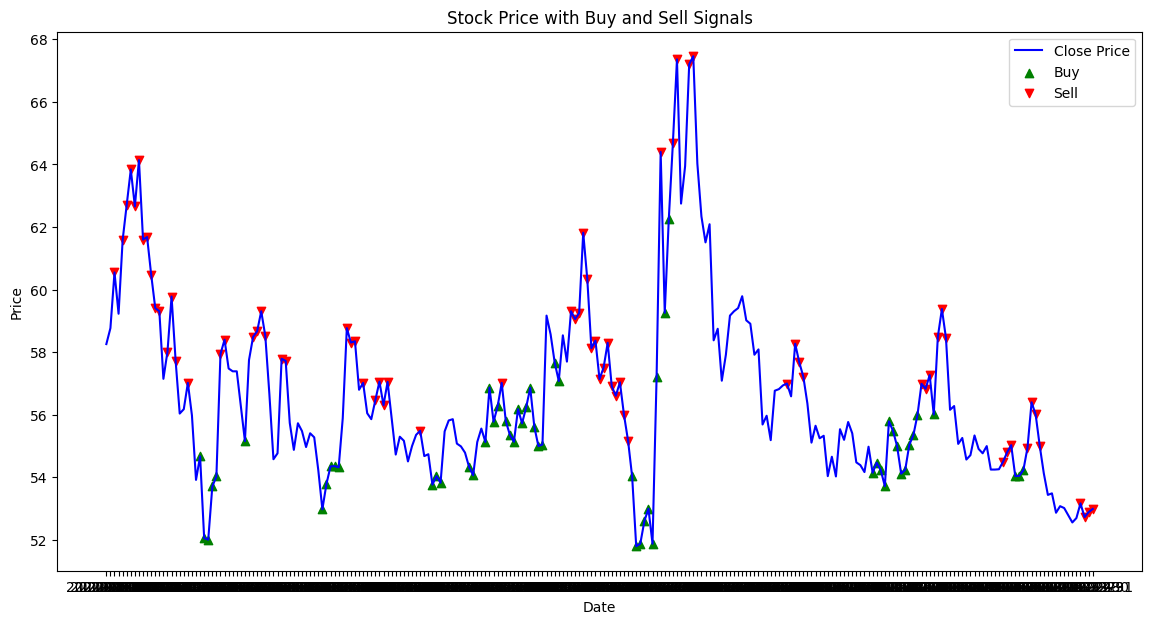

In [27]:
plot_close_label(sample_df)

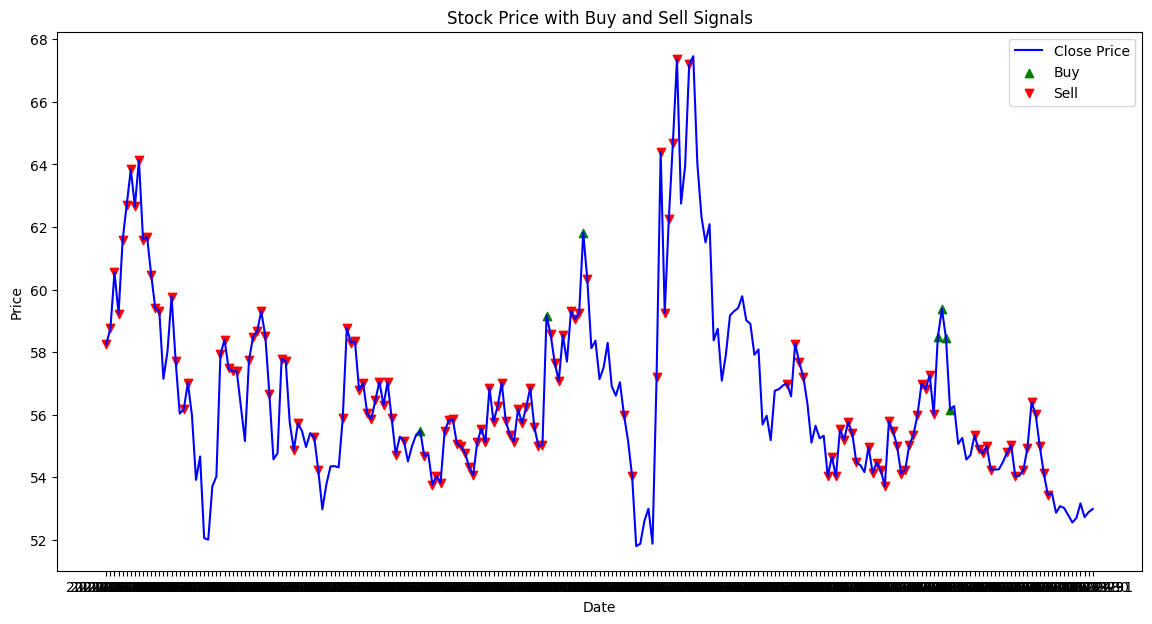

In [28]:
plot_close_label(sample_df, 'label_pred')